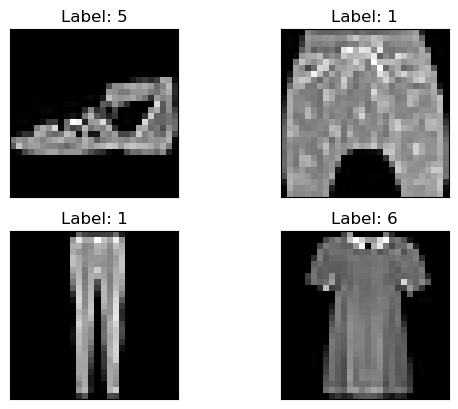

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch


# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fashion MNIST dataset
train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

# Function to show multiple images
def show_images(images, labels):
    fig = plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title("Label: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Testing the function
training_data = iter(trainLoader)
images, labels = next(training_data)
show_images(images, labels)


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 28 x 28
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            # State size: 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            # State size: 64 x 7 x 7
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [5]:
# Hyperparameters
learning_rate = 0.0002
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers

# Initialize models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))


In [6]:
# Training settings
num_epochs = 150
latent_vector_size = 100  # Size of the generator's input noise vector

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(trainLoader):
        # Prepare real images and fake images
        real_images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        real_labels = torch.ones(images.size(0), 1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        fake_labels = torch.zeros(images.size(0), 1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Train discriminator with real images
        discriminator.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Generate fake images
        noise = torch.randn(images.size(0), latent_vector_size).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainLoader)}], D_loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G_loss: {g_loss.item():.4f}')

print("Training complete.")


/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/150], Step [100/938], D_loss: 1.9340, G_loss: 0.6189
Epoch [1/150], Step [200/938], D_loss: 1.4294, G_loss: 0.7476
Epoch [1/150], Step [300/938], D_loss: 1.4206, G_loss: 0.6055
Epoch [1/150], Step [400/938], D_loss: 1.3117, G_loss: 0.8075
Epoch [1/150], Step [500/938], D_loss: 1.3473, G_loss: 0.7817
Epoch [1/150], Step [600/938], D_loss: 1.3602, G_loss: 0.7296
Epoch [1/150], Step [700/938], D_loss: 1.3173, G_loss: 0.9027
Epoch [1/150], Step [800/938], D_loss: 1.2902, G_loss: 0.8422
Epoch [1/150], Step [900/938], D_loss: 0.9627, G_loss: 1.0463
Epoch [2/150], Step [100/938], D_loss: 1.3844, G_loss: 0.8449
Epoch [2/150], Step [200/938], D_loss: 1.2625, G_loss: 0.9558
Epoch [2/150], Step [300/938], D_loss: 1.4692, G_loss: 0.7818
Epoch [2/150], Step [400/938], D_loss: 1.4865, G_loss: 1.0031
Epoch [2/150], Step [500/938], D_loss: 0.9068, G_loss: 1.1589
Epoch [2/150], Step [600/938], D_loss: 1.2824, G_loss: 1.1795
Epoch [2/150], Step [700/938], D_loss: 0.8618, G_loss: 1.1696
Epoch [2

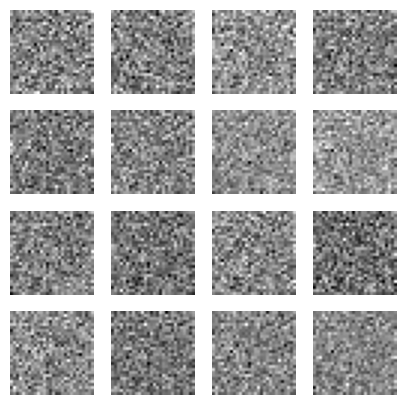

In [7]:
def plot_fake_images(generator, noise_dimension, device='cpu'):
    noise = torch.randn(16, noise_dimension, device=device)
    with torch.no_grad():
        fake_images = generator(noise).reshape(-1, 1, 28, 28)
        fake_images = fake_images.cpu().detach().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        img = fake_images[i].squeeze()  # Removing unneeded dimensions
        # Normalizing to [0, 255] scale
        img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dimension = 100
generator = Generator().to(device)  # Make sure generator is on the correct device

# Optionally, you can load the generator from a saved model here
# generator.load_state_dict(torch.load('path_to_generator_model.pth'))

plot_fake_images(generator, noise_dimension, device)
